# Tutorial: Processing Marker Data

**Author:** Robbin Romijnders  
**Date Created:** Sep 28, 2021  
**Last Modified:** Sep 28, 2021

## Introduction
In this tutorial, the data files with optical motion capture data are firstly loaded, and then the marker data are subject to the following processing steps:

1. Correct for any gaps in the marker position data, 
2. Low-pass filter the marker position data,
3. Detect any instances of intial foot contact (IC) and final foot contact (FC)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass
from lib.analysis import _get_gait_events_from_OMC
import os
from scipy.signal import find_peaks

In [2]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

# Get a list of participant ids
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
print(participant_ids[:10])



['pp001', 'pp002', 'pp003', 'pp004', 'pp005', 'pp006', 'pp007', 'pp008', 'pp009', 'pp011']


In [17]:
# Trial to investigate
trial_name = "walk_preferred"

# Loop over the participants
for (ix_participant, participant_id) in enumerate(participant_ids[14:15]):

    # Get a list of OMC data files
    omc_files = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]

    # Loop over the files
    for (ix_file, omc_file_name) in enumerate(omc_files):

        #
        if trial_name in omc_file_name:
            
            # Check if their is a corresponding IMU data file
            if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_file_name.replace("omc_", "imu_"))):
                print(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_file_name))
                print(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_file_name.replace("omc_", "imu_")))
                
                # Load optical motion capture data
                omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_file_name))

                # Load inertial motion capture data
                imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_file_name.replace("omc_", "imu_")))
                break
print(f"OMC: {omc_file_name}\nIMU: {omc_file_name.replace('omc_', 'imu_')}")

/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/pp016/optical/omc_walk_preferred.mat
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/pp016/imu/imu_walk_preferred.mat
OMC: omc_walk_preferred.mat
IMU: imu_walk_preferred.mat


We now have a dictionary, `omc_data`, that contains all the relevant information concerning our trial:
- `fs`: sampling frequency, in Hz
- `pos`: (N, 4, M) array, the marker position data, in mm; with N time steps (or frames), 3 dimensions + 1 error, M markers
- `calibration_file`: the corresponding file of the calibration procedure, in case joint angles are to be calibrated
- `marker_location`: array, with the marker positions

## Preprocessing
The marker position data are first interpolated to get rid of any missing data. Next, the data are low-pass filtered to reduce the effects of high-frequency noise.

In [18]:
# Reorganize data to comply with _predict_missing_markers() function
n_time_steps, n_markers = omc_data["pos"].shape[0], omc_data["pos"].shape[-1]
tmp = np.reshape(omc_data["pos"][:,:3,:], (n_time_steps, 3*n_markers), order="F")
tmp = _predict_missing_markers(tmp)

filled_data = np.reshape(tmp, (n_time_steps, 3, n_markers), order="F")
del tmp

In [19]:
# Low-pass filter the data
fs = omc_data["fs"]
tmp = np.reshape(filled_data, (n_time_steps, 3*n_markers), order="F")
filtered_data = _butter_lowpass(tmp, fs)
filtered_data = np.reshape(filtered_data, (n_time_steps, 3, n_markers), order="F")
del tmp

## Gait Event Detection
Now, let us detect gait events according to O'Connor *et al.* (2007) and Zeni Jr *et al.* (2008), respectively.

In [20]:
l_ix_IC, l_ix_FC, r_ix_IC, r_ix_FC = _get_gait_events_from_OMC(filtered_data, fs, omc_data["marker_location"], method="OConnor")
l_jx_IC, l_jx_FC, r_jx_IC, r_jx_FC = _get_gait_events_from_OMC(filtered_data, fs, omc_data["marker_location"], method="Zeni")

Get the marker position data, and calculate the corresponding velocity signals, according to the two papers mentioned before.

In [21]:
l_heel_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0][0]]
l_toe_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_toe')[:,0][0]]
l_psis_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_psis')[:,0][0]]

r_heel_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_heel')[:,0][0]]
r_toe_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_toe')[:,0][0]]
r_psis_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_psis')[:,0][0]]

# Get sampling frequency
fs = omc_data["fs"]

# Calculate midpoint for the posterior iliac spine markers
mid_psis_pos = ( l_psis_pos + r_psis_pos ) / 2

In [22]:
# For O'Connor et al. (2007), let us calculate the foot centre position and velocity data
l_foot_centre_pos = ( l_heel_pos + l_toe_pos ) / 2
r_foot_centre_pos = ( r_heel_pos + r_toe_pos ) / 2
l_foot_centre_vel = ( l_foot_centre_pos[1:,:] - l_foot_centre_pos[:-1,:] ) / ( 1/fs )
r_foot_centre_vel = ( r_foot_centre_pos[1:,:] - r_foot_centre_pos[:-1,:] ) / ( 1/fs )

In [23]:
# For Zeni Jr et al. (2008), let us calculate the relative position to the psis marker
l_heel_pos_rel = ( l_heel_pos - l_psis_pos )
l_toe_pos_rel = ( l_toe_pos - l_psis_pos )
r_heel_pos_rel = ( r_heel_pos - r_psis_pos )
r_toe_pos_rel = ( r_toe_pos - r_psis_pos )

In [32]:
# Visualize
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Position data
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos.shape[0]), y=l_heel_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_heel_pos[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos.shape[0]), y=l_toe_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos[l_jx_FC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos.shape[0]), y=r_heel_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_heel_pos[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos.shape[0]), y=r_toe_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='r_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos[r_jx_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)

# Velocity (O'Connor et al.)
fig.add_trace(go.Scatter(x=np.arange(l_foot_centre_vel.shape[0]), y=l_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_foot_centre_vel[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
# fig.add_trace(go.Scatter(x=l_ix_FC, y=l_foot_centre_vel[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_foot_centre_vel.shape[0]), y=r_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_foot_centre_vel[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)
# fig.add_trace(go.Scatter(x=r_ix_FC, y=r_foot_centre_vel[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)

# Relative position (Zeni Jr et al.)
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos_rel.shape[0]), y=l_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos_rel.shape[0]), y=l_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
# fig.add_trace(go.Scatter(x=l_jx_IC, y=l_heel_pos_rel[l_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos_rel[l_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos_rel.shape[0]), y=r_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos_rel.shape[0]), y=r_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
# fig.add_trace(go.Scatter(x=r_jx_IC, y=r_heel_pos_rel[r_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos_rel[r_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)

fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.show()

## Start and end of trial

In [25]:
start_1 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="start_1")[:,0][0]]
start_2 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="start_2")[:,0][0]]
end_1 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="end_1")[:,0][0]]
end_2 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="end_2")[:,0][0]]

In [26]:
start_ = ( start_1 + start_2 ) / 2
end_ = ( end_1 + end_2 ) / 2

In [27]:
def _get_distance_xy(X1, X2):
    xs = X1[:,0] - X2[:,0]
    ys = X1[:,1] - X2[:,1]
    distances = np.sqrt(xs**2 + ys**2)
    return distances

In [28]:
ix_start_ = np.argmin(_get_distance_xy(mid_psis_pos, start_))
ix_end_ = np.argmin(_get_distance_xy(mid_psis_pos, end_))

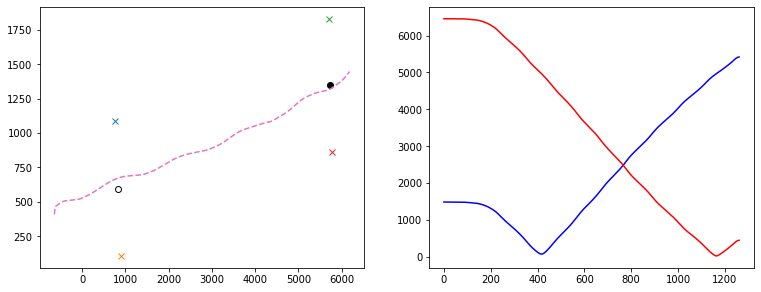

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), 'x')
ax[0].plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), 'x')
ax[0].plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 'x')
ax[0].plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 'x')
ax[0].plot(np.mean(start_[:,0]), np.mean(start_[:,1]), 'o', mec='k', mfc='none')
ax[0].plot(np.mean(end_[:,0]), np.mean(end_[:,1]), 'o', mec='k', mfc='k')
ax[0].plot(mid_psis_pos[:,0], mid_psis_pos[:,1], '--')

ax[1].plot(_get_distance_xy(mid_psis_pos, start_), '-', c='b')
ax[1].plot(_get_distance_xy(mid_psis_pos, end_), '-', c='r')

In [30]:
# Visualize
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Position data
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos.shape[0]), y=l_heel_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_heel_pos[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos.shape[0]), y=l_toe_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_FC, y=l_toe_pos[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos.shape[0]), y=r_heel_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_heel_pos[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos.shape[0]), y=r_toe_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='r_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_FC, y=r_toe_pos[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)

# Velocity (O'Connor et al.)
fig.add_trace(go.Scatter(x=np.arange(l_foot_centre_vel.shape[0]), y=l_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_foot_centre_vel[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_FC, y=l_foot_centre_vel[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_foot_centre_vel.shape[0]), y=r_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_foot_centre_vel[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_FC, y=r_foot_centre_vel[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)

# Relative position (Zeni Jr et al.)
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos_rel.shape[0]), y=l_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos_rel.shape[0]), y=l_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_IC, y=l_heel_pos_rel[l_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos_rel[l_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos_rel.shape[0]), y=r_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos_rel.shape[0]), y=r_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_IC, y=r_heel_pos_rel[r_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos_rel[r_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)

#
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=3, col=1)

fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=3, col=1)

fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.show()